In [1]:
### Imports

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

### 1. Data manipulation and cleaning

In [2]:
### Load the data
### Best strategy seems to be using the time series representation of confirmed/died/recovered

confirmed = pd.read_csv('data/time_series_19-covid-Confirmed.csv')
deaths = pd.read_csv('data/time_series_19-covid-Deaths.csv')
recovered = pd.read_csv('data/time_series_19-covid-Recovered.csv')

populations = pd.read_csv('data/population-figures-by-country-csv_csv.csv')

country_codes = pd.read_csv('data/country_codes.csv')

Examining the structure of our data; we have a wide form table with daily reported case numbers for each country, some divided by region. Each of tables are structured in the same way.

In [3]:
confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,53,59,70,75,82,114,147,177,212,272
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,581,639,639,701,773,839,825,878,889,924
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,160,178,178,200,212,226,243,266,313,345
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,129,149,149,197,238,428,566,673,790,900


In [4]:
deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,...,10,15,16,19,22,22,27,29,29,29
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,2


In [5]:
recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,...,33,34,34,35,35,35,35,41,42,42
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,...,101,118,118,118,118,118,144,144,144,150
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,78,96,96,97,105,105,109,114,114,114
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,24,26,26,26,35,42,42,49,60,75


At this stage, we are only interested in examining data on a country, rather than state/territory level. We also don't need lat/long specified in our dataframe (may need to revisit later for the map base visualisations). A wide format dataframe is not the best structure for analysing our data, we can transpose the DF and then convert the dates to a time series index.
<br><br>
This method is not dependent on the number of dates in the dataset and will continue to work as it is updated

In [6]:
# Use groupby to sum the number of cases for countries that are listed with more than one territory, then drop the lat/long columns
# .T to transpose from wide to long

confirmed = confirmed.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1).T
recovered = recovered.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1).T
deaths = deaths.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1).T

# Convert the indices to datetime
confirmed.index = pd.to_datetime(confirmed.index)
recovered.index = pd.to_datetime(recovered.index)
deaths.index = pd.to_datetime(deaths.index)

It is more convenient to merge this data into a single dataframe. This is done with pd.concat, creating multi-index columns. (https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html)

In [7]:
covid_cases = pd.concat([confirmed, recovered, deaths], axis=1, keys=['confirmed', 'recovered', 'deaths']).sort_index(axis=1)

Finally, we need to deal with any missing values. As we can see below, there are currently no missing values. This may not always be the case. Given that we are dealing with time series data, interpolation is a reasonable strategy.

In [8]:
covid_cases.isna().to_numpy().sum()

0

In [9]:
# Fill up to 5 missing values between two known values

covid_cases.interpolate(method='time', axis=0, limit=5, limit_area = 'inside', inplace=True)

### 2. Descriptive analysis and initial data exploration

In [10]:
## Set the most recent date in the dataset, this will change as more dates/data is added

most_recent_date = covid_cases.index[-1:]

**How many countries have reported at least 10 cases?**

In [11]:
## Select confirmed cases for all countries and the most recent date in the dateime index, this will work even when more dates are added
## Check to see if there are more than 10 cases (forms boolean series), then add them together

no_countries_over10 = (covid_cases.loc[most_recent_date]['confirmed'] > 10).sum(axis=1).item()
total_countries = (covid_cases.loc[most_recent_date]['confirmed']).shape[1]

print(f"{no_countries_over10} countries have reported more than 10 cases out of a total of {total_countries} countires reporting data.")

110 countries have reported more than 10 cases out of a total of 155 countires reporting data.


**What are the five countries with the highest number of active cases?**

In [12]:
## Add a separate multi-indexed column for active cases for each country, this is easiest done with stack/unstack

covid_cases = covid_cases.stack()
covid_cases['active'] = np.nan
covid_cases = covid_cases.unstack()

## Calculate active cases by active = confirmed - (recovered + deaths)
covid_cases['active'] = covid_cases['confirmed'] - (covid_cases['recovered'] + covid_cases['deaths'])

In [13]:
print("The five countries with the highest number of active cases are:")
for count, i in enumerate(covid_cases.loc[most_recent_date]['active'].T.iloc[:,0].sort_values(ascending=False)[:5].iteritems()):
    print(f'{count+1}. {i[0]} with {i[1]} active cases.')

The five countries with the highest number of active cases are:
1. Italy with 33190 active cases.
2. Spain with 16026 active cases.
3. Germany with 15163 active cases.
4. US with 13477 active cases.
5. Iran with 11413 active cases.


**What is the current rate of increase in the total number of cases, based on the last week of data?**

In [14]:
# Calculate the weekly rate of change over the last week of data

week_change = covid_cases['confirmed'].iloc[-7:].sum(axis=1)[6] - covid_cases['confirmed'].iloc[-7:].sum(axis=1)[0]

print(f"In the last week of data, the number of confirmed cases has increased globally by {week_change}.")

In the last week of data, the number of confirmed cases has increased globally by 97515.


### 3. Data normalisation

We can normalise the number of cases per million population in a country, we can do this using the population data provided in the archive. 
Additionally, we can examine timing of the outbreak in various countries by counting the days since they first reached 10 confirmed cases.

In [15]:
### Add the required columns to out dataframe

covid_cases = covid_cases.stack()
covid_cases['confirmed_per_million'] = np.nan
covid_cases['recovered_per_million'] = np.nan
covid_cases['deaths_per_million'] = np.nan
covid_cases['active_per_million'] = np.nan
covid_cases['days_since_ten'] = np.nan
covid_cases = covid_cases.unstack()

In [24]:
# Not every country as their populaton reported at the same time (see eritrea in csv), although every country in the current dataset has a 2016 population recorded
# Not ever country (e.g. Cruise Ship and Holy See) have a population
# Our loop needs to be able to handle this

country_list = covid_cases['active'].columns

for i in country_list:
    
    # Calculate cases per million for each country
    try:
        code = country_codes[country_codes.Country == i]['Country_Code'].iloc[0]
        country_populations = populations[populations.Country_Code == code].T
        millions = country_populations.loc[country_populations.last_valid_index()].item() / 1000000
    except Exception as e:
        print(e)
        print("Couldn't find population for " + i + " filling with NaN")
        millions = np.nan

    covid_cases.loc[:, ('confirmed_per_million', i)] = covid_cases.loc[:, ('confirmed', i)] / millions
    covid_cases.loc[:, ('recovered_per_million', i)] = covid_cases.loc[:, ('recovered', i)] / millions
    covid_cases.loc[:, ('deaths_per_million', i)] = covid_cases.loc[:, ('deaths', i)] / millions
    covid_cases.loc[:, ('active_per_million', i)] = covid_cases.loc[:, ('active', i)] / millions
    
    # Now calculate the days since 10 confirmed cases were reported
    
    mask = covid_cases['confirmed'][i] >= 10 # Create a boolean mask
    idx = next(iter(mask.index[mask]), np.nan) # Get the index (date) of the first true value in the boolean mask
    if pd.isnull(idx):
        covid_cases.loc[:,('days_since_ten', i)] = np.nan # If a country never reached 10 cases days_since_ten = np.nan
    else:
        covid_cases.loc[:,('days_since_ten', i)] = covid_cases['confirmed'][i].index - idx # Subtract the datetime index from all the dates to give us "day since"
    

None
Couldn't find population for Cruise Ship filling with NaN
None
Couldn't find population for Holy See filling with NaN


### 4. Further data exploration

**Which countries appear to be past the peak of their local outbreak?**

In [67]:
# List the countires had their highest daily active cases prior to the end date of the data

past_peak = []

for i in country_list:
    if covid_cases['active'][i][::-1].idxmax() < most_recent_date: # Find the date that the highest active cases occurred on and check if it was before the latest date
        print(i)
        past_peak.append(i)

Algeria
China
Cruise Ship
Greece
Korea, South
Nepal


We can further examine these countries visually to see which are "past the peak".

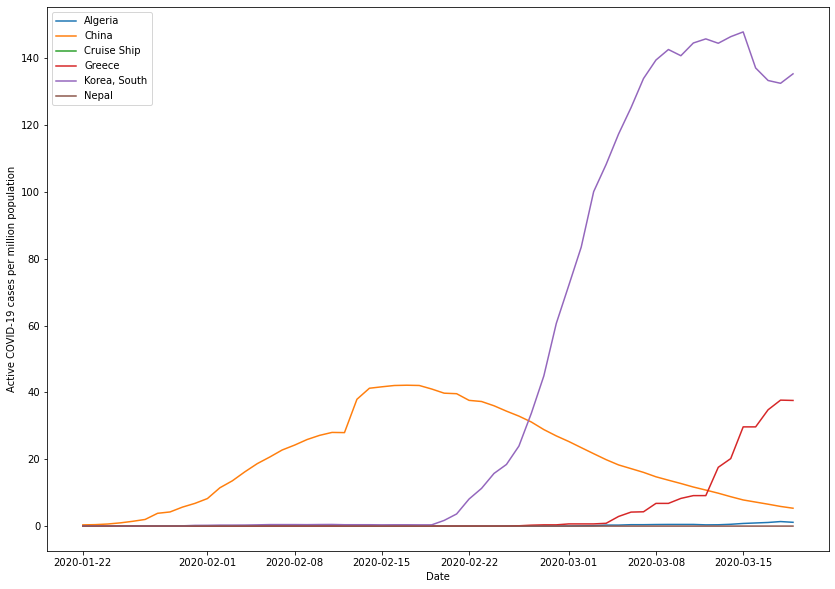

In [72]:
plt.figure(figsize=(14,10))
plt.xlabel("Date")
plt.ylabel("Active COVID-19 cases per million population")

for i in past_peak:
    plt.plot(covid_cases['active_per_million'][i], label=i)
    
plt.legend()

Following visual inspection:
- China and South Korea appear to be definitively passed their peak
- Greece may have passed their peak, but it's difficult to definitively say
- Algeria and Nepal both have small case numbers, which make it difficult to interpret the peak
- Cruise Ships are not a country

**What can you say about how long it takes for the outbreak to peak?**<br>
We can only confidently identify the peak with reasonable confidence in China, South Korea and Greece.

In [105]:
peaked = ['China', 'Korea, South', 'Greece']

days_to_peak = []

for i in peaked:
    peak_idx = covid_cases['active'][i][::-1].idxmax() 
    days_to_peak.append(covid_cases.loc[peak_idx, ('days_since_ten', i)].days)
    
mean_days_to_peak = np.mean(days_to_peak)
std_days_to_peak = np.std(days_to_peak)

print(f"Of the three countries to have peaked the peak occured {np.round(mean_days_to_peak, 2)} ± {np.round(std_days_to_peak, 2)} days after reaching 10 confirmed cases.")

Of the three countries to have peaked the peak occured 27.67 ± 12.71 days after reaching 10 confirmed cases.
